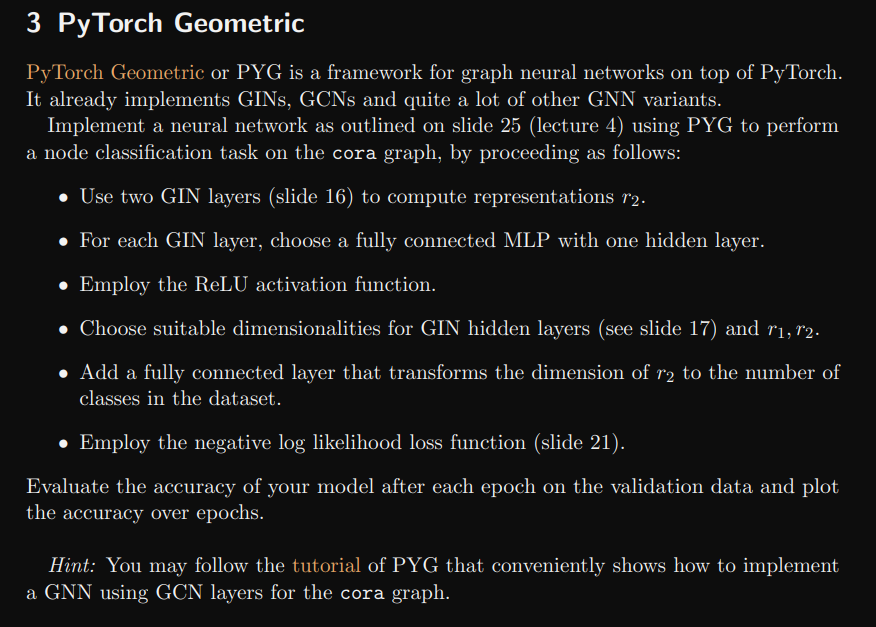

In [2]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu116.html
     |████████████████████████████████| 8.0 MB 5.3 MB/s 
     |████████████████████████████████| 3.5 MB 49.6 MB/s 
     |████████████████████████████████| 2.4 MB 43.8 MB/s 
     |████████████████████████████████| 706 kB 45.0 MB/s 
     |████████████████████████████████| 467 kB 5.0 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=d8053857545bd9962413b8fcd460869860bff5e684247908d1c77ee8c1ef224d
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [3]:
import torch_geometric
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [6]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8050
